In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import ast

import gurobipy as gp
from gurobipy import GRB, Model
import math

import warnings
warnings.filterwarnings('ignore')

In [2]:
path = os.getcwd()
filenames = [file for file in os.listdir() if file.endswith(".csv")]

for file in filenames:
    key = file.split("_")[-1].split("datapoints")[0] 
    variable_name = f"df_{key}"
    
    df = pd.read_csv(os.path.join(file))
    exec(f"{variable_name} = df") # 30, 60, 90, 180, 365

In [3]:
df_30

,Period,Lookback_Days,portfolio_risk,stock,weight
0,2023-01,30.0,19.999983,"['BCIC.JK', 'EXCL.JK', 'SINI.JK']","[0.1, 0.08, 0.82]"
1,2023-02,30.0,7.920006,"['BRIS.JK', 'WINE.JK']","[0.1, 0.9]"
2,2023-03,30.0,4.374988,"['AMAR.JK', 'CHIP.JK']","[0.1, 0.9]"
3,2023-04,30.0,4.653722,"['BBSI.JK', 'BMAS.JK', 'CHIP.JK']","[0.0, 0.1, 0.9]"
4,2023-05,30.0,9.452061,"['CUAN.JK', 'NISP.JK']","[0.9, 0.1]"
5,2023-06,30.0,10.075249,"['HITS.JK', 'NISP.JK']","[0.9, 0.1]"
6,2023-07,30.0,9.497290,"['BBHI.JK', 'UNIQ.JK']","[0.1, 0.9]"
7,2023-08,30.0,8.821746,"['ALKA.JK', 'BNBA.JK']","[0.9, 0.1]"
8,2023-09,30.0,10.163003,"['IKBI.JK', 'NOBU.JK']","[0.9, 0.1]"
9,2023-10,30.0,12.144997,"['NOBU.JK', 'POLU.JK']","[0.1, 0.9]"


In [4]:
df_30.dropna(inplace=True)

In [5]:
df_30

,Period,Lookback_Days,portfolio_risk,stock,weight
0,2023-01,30.0,19.999983,"['BCIC.JK', 'EXCL.JK', 'SINI.JK']","[0.1, 0.08, 0.82]"
1,2023-02,30.0,7.920006,"['BRIS.JK', 'WINE.JK']","[0.1, 0.9]"
2,2023-03,30.0,4.374988,"['AMAR.JK', 'CHIP.JK']","[0.1, 0.9]"
3,2023-04,30.0,4.653722,"['BBSI.JK', 'BMAS.JK', 'CHIP.JK']","[0.0, 0.1, 0.9]"
4,2023-05,30.0,9.452061,"['CUAN.JK', 'NISP.JK']","[0.9, 0.1]"
5,2023-06,30.0,10.075249,"['HITS.JK', 'NISP.JK']","[0.9, 0.1]"
6,2023-07,30.0,9.497290,"['BBHI.JK', 'UNIQ.JK']","[0.1, 0.9]"
7,2023-08,30.0,8.821746,"['ALKA.JK', 'BNBA.JK']","[0.9, 0.1]"
8,2023-09,30.0,10.163003,"['IKBI.JK', 'NOBU.JK']","[0.9, 0.1]"
9,2023-10,30.0,12.144997,"['NOBU.JK', 'POLU.JK']","[0.1, 0.9]"


In [6]:
df_30.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12 entries, 0 to 11
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Period          12 non-null     object 
 1   Lookback_Days   12 non-null     float64
 2   portfolio_risk  12 non-null     float64
 3   stock           12 non-null     object 
 4   weight          12 non-null     object 
dtypes: float64(2), object(3)
memory usage: 576.0+ bytes


In [7]:
path

'D:\\College Stuff\\Smt 7\\MSIB\\DDB\\Task 2\\data\\monthly'

In [8]:
monthly_returns = pd.read_csv(path + "\\tickers\\tickers_monthly_returns_percentage_2023.csv")
monthly_returns

,ticker,month,monthly_return_percentage
0,PJAA.JK,2023-01,-2.816654
1,PJAA.JK,2023-02,-1.449144
2,PJAA.JK,2023-03,0.000000
3,PJAA.JK,2023-04,1.428444
4,PJAA.JK,2023-05,2.554153
...,...,...,...
10439,BABY.JK,2023-12,-15.714286
10440,AEGS.JK,2023-09,-32.631579
10441,AEGS.JK,2023-10,-15.873016
10442,AEGS.JK,2023-11,18.367347


In [9]:
# parsing string list
def parse_column(column):
    return column.apply(lambda x: ast.literal_eval(x))

# simulasi portfolio
def simulate_portfolio(df, monthly_returns, initial_fund=1e8): # 100_000_000
    portfolio_value = initial_fund
    portfolio_history = []

    for i, row in df.iterrows():
        month = row['Period']
        stock_list = row['stock']
        weights = row['weight']

        # alokasi setiap bulan
        stock_allocations = {stock: portfolio_value * float(weight) for stock, weight in zip(stock_list, weights)}
        
        # update nilai alokasi
        for stock, allocation in stock_allocations.items():
            stock_return = monthly_returns[(monthly_returns['ticker'] == stock) & (monthly_returns['month'] == month)]
            if not stock_return.empty:
                # persentase return bulanan
                return_percentage = float(stock_return['monthly_return_percentage'].values[0]) / 100
                # update nilai alokasi saham berdasarkan return bulanan
                stock_allocations[stock] = allocation * (1 + return_percentage)

        # total nilai total portofolio setelah return
        portfolio_value = sum(stock_allocations.values())
        portfolio_history.append({'Period': month, 'portfolio_value': portfolio_value})

    return pd.DataFrame(portfolio_history)

In [10]:
# lookback 30 days
df_30['stock'] = parse_column(df_30['stock'])
df_30['weight'] = parse_column(df_30['weight'])

portfolio_history_30 = simulate_portfolio(df_30, monthly_returns)
portfolio_history_30

,Period,portfolio_value
0,2023-01,9.628093e+07
1,2023-02,9.027224e+07
2,2023-03,2.331392e+08
3,2023-04,2.568124e+08
4,2023-05,2.345657e+08
5,2023-06,2.382272e+08
6,2023-07,3.116366e+08
7,2023-08,2.460590e+08
8,2023-09,2.437400e+08
9,2023-10,2.424738e+08


In [11]:
# lookback 60 days
df_60['stock'] = parse_column(df_60['stock'])
df_60['weight'] = parse_column(df_60['weight'])

portfolio_history_60 = simulate_portfolio(df_60, monthly_returns)
portfolio_history_60

,Period,portfolio_value
0,2023-01,9.862595e+07
1,2023-02,1.679170e+08
2,2023-03,4.339939e+08
3,2023-04,4.831996e+08
4,2023-05,4.917652e+08
5,2023-06,5.009418e+08
6,2023-07,6.075381e+08
7,2023-08,3.444227e+08
8,2023-09,3.356064e+08
9,2023-10,3.324838e+08


In [12]:
# lookback 90 days
df_90['stock'] = parse_column(df_90['stock'])
df_90['weight'] = parse_column(df_90['weight'])

portfolio_history_90 = simulate_portfolio(df_90, monthly_returns)
portfolio_history_90

,Period,portfolio_value
0,2023-01,9.899254e+07
1,2023-02,8.311636e+07
2,2023-03,6.892191e+07
3,2023-04,7.592031e+07
4,2023-05,7.761775e+07
5,2023-06,7.906614e+07
6,2023-07,8.376670e+07
7,2023-08,1.093176e+08
8,2023-09,1.401619e+08
9,2023-10,1.780358e+08


In [13]:
# lookback 180 days
df_180['stock'] = parse_column(df_180['stock'])
df_180['weight'] = parse_column(df_180['weight'])

portfolio_history_180 = simulate_portfolio(df_180, monthly_returns)
portfolio_history_180

,Period,portfolio_value
0,2023-01,9.065481e+07
1,2023-02,7.483514e+07
2,2023-03,6.205494e+07
3,2023-04,6.913175e+07
4,2023-05,7.049279e+07
5,2023-06,7.070785e+07
6,2023-07,7.491150e+07
7,2023-08,8.152192e+07
8,2023-09,9.668033e+07
9,2023-10,1.036480e+08


In [14]:
# lookback 30 days
df_365['stock'] = parse_column(df_365['stock'])
df_365['weight'] = parse_column(df_365['weight'])

portfolio_history_365 = simulate_portfolio(df_365, monthly_returns)
portfolio_history_365

,Period,portfolio_value
0,2023-01,9.587771e+07
1,2023-02,9.210024e+07
2,2023-03,8.542341e+07
3,2023-04,8.333339e+07
4,2023-05,8.198854e+07
5,2023-06,8.351849e+07
6,2023-07,8.848374e+07
7,2023-08,9.629182e+07
8,2023-09,1.143770e+08
9,2023-10,1.226201e+08


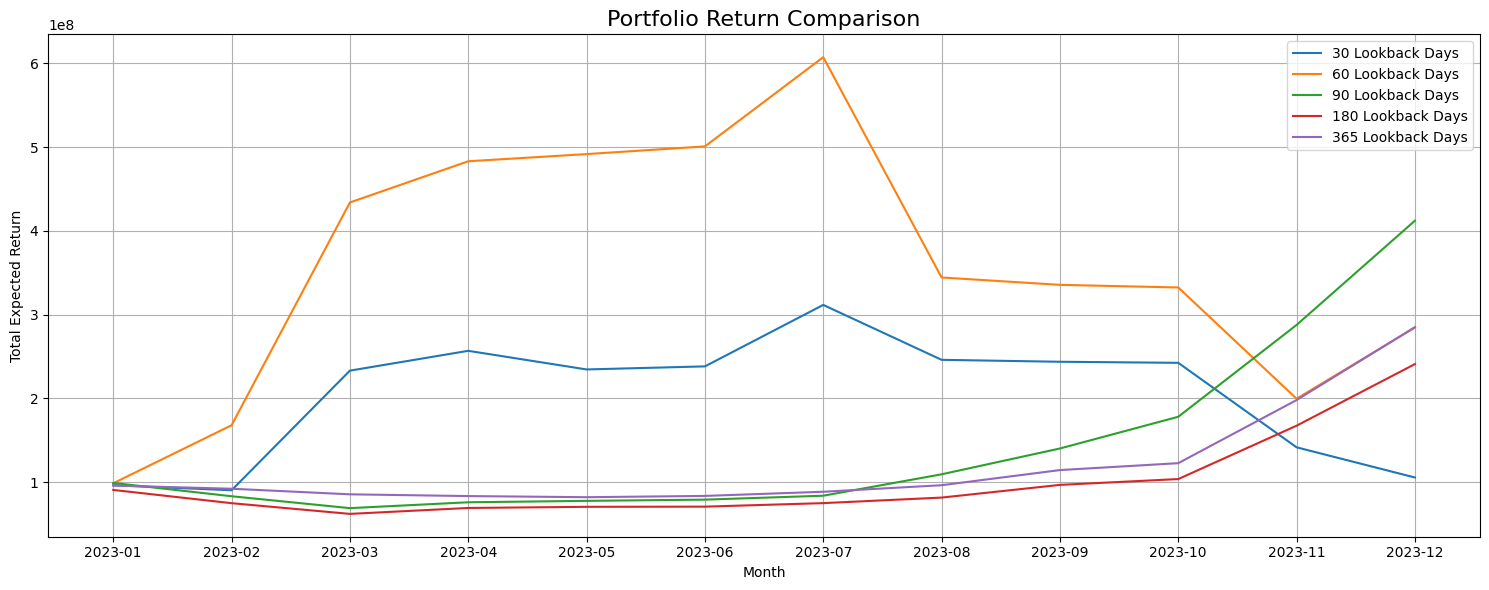

In [15]:
dataframes = [portfolio_history_30,
              portfolio_history_60,
              portfolio_history_90,
              portfolio_history_180,
              portfolio_history_365]
labels = ["30 Lookback Days",
          "60 Lookback Days",
          "90 Lookback Days",
          "180 Lookback Days",
          "365 Lookback Days"]

plt.figure(figsize=(15, 6))
for df, label in zip(dataframes, labels):
    plt.plot(df['Period'], df['portfolio_value'], label=label)

plt.xlabel('Month')
plt.ylabel('Total Expected Return')
plt.title('Portfolio Return Comparison', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
def calculate_metrics(df_1, df_2, label):
    annualized_return = (df_2['portfolio_value'].iloc[-1] / df_2['portfolio_value'].iloc[0] - 1) * 100
    volatility = df_1['portfolio_risk'].iloc[-1]
    # drawdown = max(0, (df_2['portfolio_value'].max() - df_2['portfolio_value'].min()))

    return {
        'Label': label,
        'Annualized Return': f"{annualized_return:.2f}%",
        'Risk - Volatility': f"{volatility:.2f}%",
        # 'Drawdown': f"{drawdown:.2f}%",
    }

metrics_list = []
metrics_list.append(calculate_metrics(df_30, portfolio_history_30, "30 Lookback Days Portfolio"))
metrics_list.append(calculate_metrics(df_60, portfolio_history_60, "60 Lookback Days Portfolio"))
metrics_list.append(calculate_metrics(df_90, portfolio_history_90, "90 Lookback Days Portfolio"))
metrics_list.append(calculate_metrics(df_180, portfolio_history_180, "180 Lookback Days Portfolio"))
metrics_list.append(calculate_metrics(df_365, portfolio_history_365, "365 Lookback Days Portfolio"))

print("Highlights")
# print("Return")
for metrics in metrics_list:
    print(f"{metrics['Label']}:")
    print(f"  Annualized Return: {metrics['Annualized Return']}")
    print(f"  Risk - Volatility: {metrics['Risk - Volatility']}")
    # print(f"  Drawdown: {metrics['Drawdown']}")
    print()


Highlights
30 Lookback Days Portfolio:
  Annualized Return: 9.60%
  Risk - Volatility: 12.76%

60 Lookback Days Portfolio:
  Annualized Return: 188.55%
  Risk - Volatility: 5.79%

90 Lookback Days Portfolio:
  Annualized Return: 316.41%
  Risk - Volatility: 5.81%

180 Lookback Days Portfolio:
  Annualized Return: 165.80%
  Risk - Volatility: 6.14%

365 Lookback Days Portfolio:
  Annualized Return: 197.32%
  Risk - Volatility: 4.42%



# LQ45

In [17]:
df_lq45 = pd.read_csv(path + "\\lq45\\data_historis_jakarta_stock_exchange_lq45.csv")
df_lq45['Tanggal'] = pd.to_datetime(df_lq45['Tanggal'], format='%d/%m/%Y').dt.strftime('%Y-%m-%d')

In [18]:
# replace commas & convert to float
columns = ['Terakhir', 'Pembukaan', 'Tertinggi', 'Terendah']
for col in columns:
    df_lq45[col] = df_lq45[col].str.replace('.', '').str.replace(',', '.').astype(float)

In [19]:
df_lq45 = df_lq45.sort_values(by='Tanggal').reset_index(drop=True)
df_lq45

,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah,Vol.,Perubahan%
0,2020-01-02,1011.62,1017.16,1017.52,1007.50,"612,73M","-0,28%"
1,2020-01-03,1021.49,1016.72,1021.49,1012.97,"1,08B","0,98%"
2,2020-01-06,1010.23,1012.93,1016.16,1005.83,"1,12B","-1,10%"
3,2020-01-07,1014.64,1013.78,1016.53,1008.49,"1,19B","0,44%"
4,2020-01-08,1005.45,1007.10,1010.44,1004.10,"1,37B","-0,91%"
...,...,...,...,...,...,...,...
1144,2024-09-20,973.20,979.44,981.16,971.35,"14,75B","-0,66%"
1145,2024-09-23,985.26,973.10,985.26,972.10,"7,25B","1,24%"
1146,2024-09-24,985.41,984.91,988.27,983.06,"5,49B","0,02%"
1147,2024-09-25,977.15,979.45,980.72,958.70,"14,28B","-0,84%"


In [20]:
start_date = pd.Timestamp('2022-12-31')
end_date = pd.Timestamp('2023-12-31')

df_lq45['Tanggal'] = pd.to_datetime(df_lq45['Tanggal'], format='%Y-%m-%d')
filtered_df_lq45 = df_lq45[(df_lq45['Tanggal'] >= start_date) & (df_lq45['Tanggal'] <= end_date)]
filtered_df_lq45 = filtered_df_lq45.reset_index(drop=True)

In [21]:
# convert 'Perubahan%' to float
filtered_df_lq45['Perubahan%'] = filtered_df_lq45['Perubahan%'].str.replace(",", ".")
filtered_df_lq45['Perubahan%'] = filtered_df_lq45['Perubahan%'].str.rstrip('%').astype(float)

In [22]:
def convert_number(s):
    if isinstance(s, str):
        s = s.replace(",", ".")
        if 'M' in s:
            return float(s.replace("M", "")) * 1e6
        elif 'B' in s:
            return float(s.replace("B", "")) * 1e9
        else:
            return float(s)
    else:
        return s

In [23]:
filtered_df_lq45['Vol.'] = filtered_df_lq45['Vol.'].apply(convert_number)
filtered_df_lq45['Vol.']

0      1.540000e+09
1      3.860000e+09
2      3.280000e+09
3      3.940000e+09
4      2.190000e+09
           ...     
235    2.560000e+09
236             NaN
237    2.880000e+09
238    2.790000e+09
239    2.850000e+09
Name: Vol., Length: 240, dtype: float64

In [24]:
filtered_df_lq45

,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah,Vol.,Perubahan%
0,2023-01-02,935.08,937.20,937.22,929.77,1.540000e+09,-0.22
1,2023-01-03,940.46,935.08,945.03,931.78,3.860000e+09,0.57
2,2023-01-04,928.53,940.46,941.88,928.53,3.280000e+09,-1.27
3,2023-01-05,909.66,928.54,928.57,902.98,3.940000e+09,-2.03
4,2023-01-06,913.02,909.65,913.98,899.61,2.190000e+09,0.37
...,...,...,...,...,...,...,...
235,2023-12-22,967.36,967.68,969.99,964.74,2.560000e+09,0.33
236,2023-12-26,967.36,967.68,969.99,964.74,NaN,0.00
237,2023-12-27,968.73,971.35,973.96,967.90,2.880000e+09,0.14
238,2023-12-28,977.07,973.18,979.40,971.76,2.790000e+09,0.86


In [25]:
filtered_df_lq45 = filtered_df_lq45.ffill(axis=0)
filtered_df_lq45

,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah,Vol.,Perubahan%
0,2023-01-02,935.08,937.20,937.22,929.77,1.540000e+09,-0.22
1,2023-01-03,940.46,935.08,945.03,931.78,3.860000e+09,0.57
2,2023-01-04,928.53,940.46,941.88,928.53,3.280000e+09,-1.27
3,2023-01-05,909.66,928.54,928.57,902.98,3.940000e+09,-2.03
4,2023-01-06,913.02,909.65,913.98,899.61,2.190000e+09,0.37
...,...,...,...,...,...,...,...
235,2023-12-22,967.36,967.68,969.99,964.74,2.560000e+09,0.33
236,2023-12-26,967.36,967.68,969.99,964.74,2.560000e+09,0.00
237,2023-12-27,968.73,971.35,973.96,967.90,2.880000e+09,0.14
238,2023-12-28,977.07,973.18,979.40,971.76,2.790000e+09,0.86


In [26]:
def aggregate_monthly_returns_perubahan(df):
    # 'month' untuk agregasi per bulan
    df['Period'] = df['Tanggal'].dt.to_period('M')
    
    # Agregasi return bulanan dari 'Perubahan%' tertimbang volume
    monthly_returns = df.groupby('Period').apply(
        lambda x: (x['Perubahan%'] * x['Vol.']).sum() / x['Vol.'].sum()
    ).reset_index(name='weighted_return_percentage')

    # monthly risk
    monthly_risk = df.groupby('Period').apply(
        lambda x: ((x['Perubahan%'] - x['Perubahan%'].mean()) ** 2).mean() ** 0.5
    ).reset_index(name='monthly_return_stddev')  # stdev
    
    return pd.merge(monthly_returns, monthly_risk, on='Period')

def simulate_portfolio_lq45(monthly_returns, initial_fund=1e8):
    portfolio_value = initial_fund
    portfolio_history = []

    # looping setiap bulan di monthly_returns
    for i, row in monthly_returns.iterrows():
        month = row['Period']
        return_percentage = row['weighted_return_percentage'] / 100
        portfolio_risk = row['monthly_return_stddev'] / 100
        
        # update nilai portofolio berdasarkan return bulanan tertimbang
        portfolio_value *= (1 + return_percentage)

        portfolio_history.append({'Period': str(month),
                                  'portfolio_value': portfolio_value,
                                  'portfolio_risk': portfolio_risk})

    return pd.DataFrame(portfolio_history)

In [27]:
monthly_returns_lq45 = aggregate_monthly_returns_perubahan(filtered_df_lq45)
portfolio_history_lq45 = simulate_portfolio_lq45(monthly_returns_lq45)

# simulasi
portfolio_history_lq45

,Period,portfolio_value,portfolio_risk
0,2023-01,1.001070e+08,0.009543
1,2023-02,1.001399e+08,0.005347
2,2023-03,1.005933e+08,0.009892
3,2023-04,1.007773e+08,0.005747
4,2023-05,1.009301e+08,0.006088
5,2023-06,1.009314e+08,0.004061
6,2023-07,1.010254e+08,0.004941
7,2023-08,1.010203e+08,0.004742
8,2023-09,1.009239e+08,0.005400
9,2023-10,1.005497e+08,0.007691


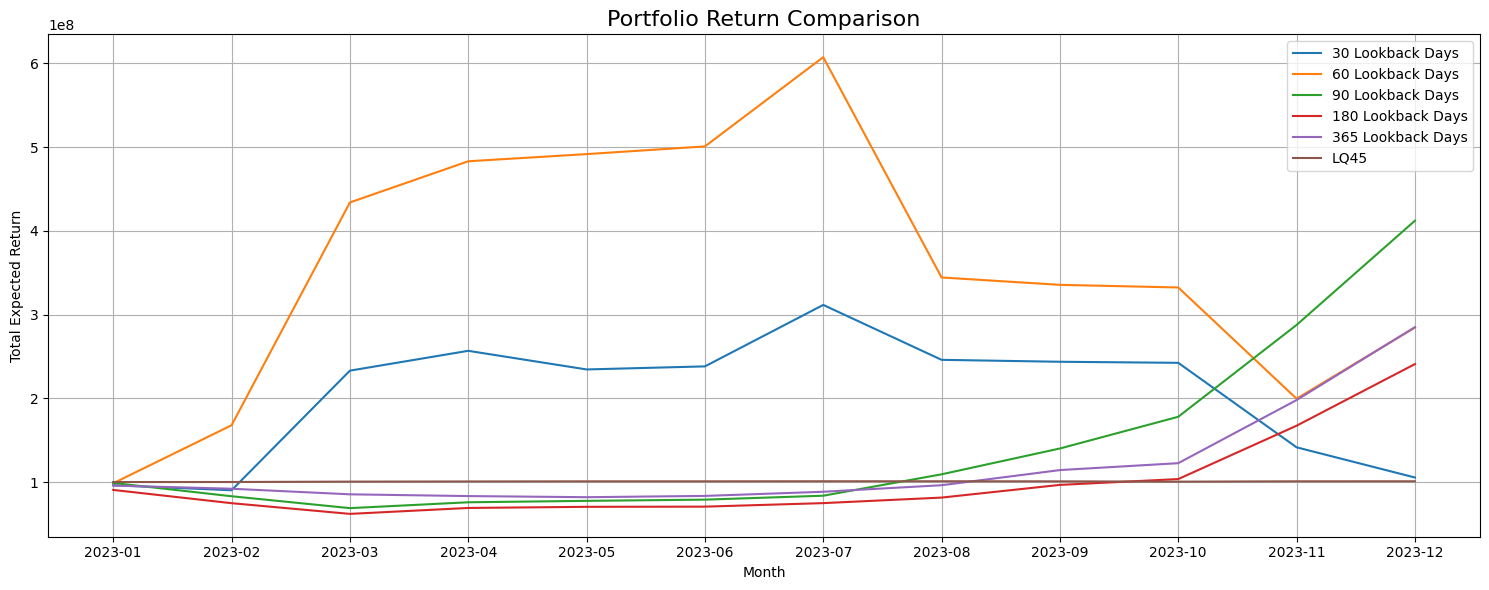

In [28]:
dataframes = [portfolio_history_30,
              portfolio_history_60,
              portfolio_history_90,
              portfolio_history_180,
              portfolio_history_365,
              portfolio_history_lq45]
labels = ["30 Lookback Days",
          "60 Lookback Days",
          "90 Lookback Days",
          "180 Lookback Days",
          "365 Lookback Days",
          "LQ45"]

plt.figure(figsize=(15, 6))
for df, label in zip(dataframes, labels):
    plt.plot(df['Period'], df['portfolio_value'], label=label)

plt.xlabel('Month')
plt.ylabel('Total Expected Return')
plt.title('Portfolio Return Comparison', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [29]:
def calculate_metrics(df_1, df_2, label):
    annualized_return = (df_2['portfolio_value'].iloc[-1] / df_2['portfolio_value'].iloc[0] - 1) * 100
    # volatility = df_1['portfolio_risk'].iloc[-1]
    # drawdown = max(0, (df_2['portfolio_value'].max() - df_2['portfolio_value'].min()))

    return {
        'Label': label,
        'Annualized Return': f"{annualized_return:.2f}%",
        # 'Risk - Volatility': f"{volatility:.2f}%",
        # 'Drawdown': f"{drawdown:.2f}%",
    }

metrics_list = []
metrics_list.append(calculate_metrics(df_30, portfolio_history_30, "30 Lookback Days Portfolio"))
metrics_list.append(calculate_metrics(df_60, portfolio_history_60, "60 Lookback Days Portfolio"))
metrics_list.append(calculate_metrics(df_90, portfolio_history_90, "90 Lookback Days Portfolio"))
metrics_list.append(calculate_metrics(df_180, portfolio_history_180, "180 Lookback Days Portfolio"))
metrics_list.append(calculate_metrics(df_365, portfolio_history_365, "365 Lookback Days Portfolio"))
metrics_list.append(calculate_metrics(portfolio_history_lq45, portfolio_history_lq45, "LQ45"))

print("Highlights")
# print("Return")
for metrics in metrics_list:
    print(f"{metrics['Label']}:")
    print(f"  Annualized Return: {metrics['Annualized Return']}")
    # print(f"  Risk - Volatility: {metrics['Risk - Volatility']}")
    # print(f"  Drawdown: {metrics['Drawdown']}")
    print()


Highlights
30 Lookback Days Portfolio:
  Annualized Return: 9.60%

60 Lookback Days Portfolio:
  Annualized Return: 188.55%

90 Lookback Days Portfolio:
  Annualized Return: 316.41%

180 Lookback Days Portfolio:
  Annualized Return: 165.80%

365 Lookback Days Portfolio:
  Annualized Return: 197.32%

LQ45:
  Annualized Return: 0.88%



In [30]:
# ========= KODE TAMBAHAN ========= #

In [31]:
df_30

,Period,Lookback_Days,portfolio_risk,stock,weight
0,2023-01,30.0,19.999983,"[BCIC.JK, EXCL.JK, SINI.JK]","[0.1, 0.08, 0.82]"
1,2023-02,30.0,7.920006,"[BRIS.JK, WINE.JK]","[0.1, 0.9]"
2,2023-03,30.0,4.374988,"[AMAR.JK, CHIP.JK]","[0.1, 0.9]"
3,2023-04,30.0,4.653722,"[BBSI.JK, BMAS.JK, CHIP.JK]","[0.0, 0.1, 0.9]"
4,2023-05,30.0,9.452061,"[CUAN.JK, NISP.JK]","[0.9, 0.1]"
5,2023-06,30.0,10.075249,"[HITS.JK, NISP.JK]","[0.9, 0.1]"
6,2023-07,30.0,9.497290,"[BBHI.JK, UNIQ.JK]","[0.1, 0.9]"
7,2023-08,30.0,8.821746,"[ALKA.JK, BNBA.JK]","[0.9, 0.1]"
8,2023-09,30.0,10.163003,"[IKBI.JK, NOBU.JK]","[0.9, 0.1]"
9,2023-10,30.0,12.144997,"[NOBU.JK, POLU.JK]","[0.1, 0.9]"


In [32]:
df_30.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12 entries, 0 to 11
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Period          12 non-null     object 
 1   Lookback_Days   12 non-null     float64
 2   portfolio_risk  12 non-null     float64
 3   stock           12 non-null     object 
 4   weight          12 non-null     object 
dtypes: float64(2), object(3)
memory usage: 576.0+ bytes


In [33]:
final_30 = pd.DataFrame({
    'Period': df_30['Period'].values,
    'Lookback_Days': 30, 
    'portfolio_risk': df_30['portfolio_risk'].values, 
    'stock': df_30['stock'].values, 
    'weight': df_30['weight'].values, 
    'Init_Cap': np.nan, 
    'Weighted_Invest': np.nan, 
    'Return/Loss_Percentage': np.nan, 
    'Cap_Gain/Loss': np.nan, 
    'Final_Cap': np.nan 
})

final_30

,Period,Lookback_Days,portfolio_risk,stock,weight,Init_Cap,Weighted_Invest,Return/Loss_Percentage,Cap_Gain/Loss,Final_Cap
0,2023-01,30,19.999983,"[BCIC.JK, EXCL.JK, SINI.JK]","[0.1, 0.08, 0.82]",NaN,NaN,NaN,NaN,NaN
1,2023-02,30,7.920006,"[BRIS.JK, WINE.JK]","[0.1, 0.9]",NaN,NaN,NaN,NaN,NaN
2,2023-03,30,4.374988,"[AMAR.JK, CHIP.JK]","[0.1, 0.9]",NaN,NaN,NaN,NaN,NaN
3,2023-04,30,4.653722,"[BBSI.JK, BMAS.JK, CHIP.JK]","[0.0, 0.1, 0.9]",NaN,NaN,NaN,NaN,NaN
4,2023-05,30,9.452061,"[CUAN.JK, NISP.JK]","[0.9, 0.1]",NaN,NaN,NaN,NaN,NaN
5,2023-06,30,10.075249,"[HITS.JK, NISP.JK]","[0.9, 0.1]",NaN,NaN,NaN,NaN,NaN
6,2023-07,30,9.497290,"[BBHI.JK, UNIQ.JK]","[0.1, 0.9]",NaN,NaN,NaN,NaN,NaN
7,2023-08,30,8.821746,"[ALKA.JK, BNBA.JK]","[0.9, 0.1]",NaN,NaN,NaN,NaN,NaN
8,2023-09,30,10.163003,"[IKBI.JK, NOBU.JK]","[0.9, 0.1]",NaN,NaN,NaN,NaN,NaN
9,2023-10,30,12.144997,"[NOBU.JK, POLU.JK]","[0.1, 0.9]",NaN,NaN,NaN,NaN,NaN


In [34]:
def calculate_portfolio(df, monthly_returns):
    initial_cap = 1e8   # dana awal
    # kolom baru
    df['Init_Cap'] = 0.0
    df['Weighted_Invest'] = pd.Series(dtype='object')
    df['Cap_Gain/Loss'] = pd.Series(dtype='object')
    df['Return/Loss_Percentage'] = pd.Series(dtype='object')
    df['Final_Cap'] = 0.0

    for i in range(len(df)):
        # set nilai Init_Cap
        if i == 0:
            df.at[i, 'Init_Cap'] = initial_cap
        else:
            df.at[i, 'Init_Cap'] = df.at[i-1, 'Final_Cap']

        # Weighted_Invest (alokasi investasi per saham berdasarkan bobot), pembulatan 2 desimal
        df.at[i, 'Weighted_Invest'] = [round(w * df.at[i, 'Init_Cap'], 2) for w in df.at[i, 'weight']]

        # Get stock symbols and the corresponding month
        stocks = df.at[i, 'stock']
        month = df.at[i, 'Period']  # 'Period' YYYY-MM format

        # return percentages untuk stocks pada setiap bulan
        stock_returns = []
        for stock in stocks:
            monthly_return = monthly_returns.loc[
                (monthly_returns['ticker'] == stock) & (monthly_returns['month'] == month),
                'monthly_return_percentage'
            ]
            stock_returns.append(monthly_return.values[0] if not monthly_return.empty else 0)  # default 0 jika tidak ada data

        # Cap_Gain/Lost, pembulatan 2 desimal
        df.at[i, 'Cap_Gain/Loss'] = [round(w_invest * (ret / 100), 2) for w_invest, ret in zip(df.at[i, 'Weighted_Invest'], stock_returns)]

        # Final_Cap = Init_Cap + jumlah Cap_Gain/Loss
        df.at[i, 'Final_Cap'] = df.at[i, 'Init_Cap'] + sum(df.at[i, 'Cap_Gain/Loss'])
        
        # Return/Loss Percentage, pembulatan 2 desimal
        return_loss_percentage = [round((gain_loss / invest) * 100, 2) if invest != 0 else 0 for gain_loss, invest in zip(df.at[i, 'Cap_Gain/Loss'], df.at[i, 'Weighted_Invest'])]
        df.at[i, 'Return/Loss_Percentage'] = return_loss_percentage

    return df

In [35]:
final_30 = calculate_portfolio(final_30, monthly_returns)
final_30

,Period,Lookback_Days,portfolio_risk,stock,weight,Init_Cap,Weighted_Invest,Return/Loss_Percentage,Cap_Gain/Loss,Final_Cap
0,2023-01,30,19.999983,"[BCIC.JK, EXCL.JK, SINI.JK]","[0.1, 0.08, 0.82]",1.000000e+08,"[10000000.0, 8000000.0, 82000000.0]","[-32.8, 5.99, -1.12]","[-3280423.28, 479262.67, -917910.45]",9.628093e+07
1,2023-02,30,7.920006,"[BRIS.JK, WINE.JK]","[0.1, 0.9]",9.628093e+07,"[9628092.89, 86652836.05]","[13.01, -8.38]","[1252725.84, -7261410.84]",9.027224e+07
2,2023-03,30,4.374988,"[AMAR.JK, CHIP.JK]","[0.1, 0.9]",9.027224e+07,"[9027224.39, 81245019.55]","[3.38, 175.47]","[304973.8, 142562015.44]",2.331392e+08
3,2023-04,30,4.653722,"[BBSI.JK, BMAS.JK, CHIP.JK]","[0.0, 0.1, 0.9]",2.331392e+08,"[0.0, 23313923.32, 209825309.86]","[0, -12.5, 12.67]","[0.0, -2914240.42, 26587453.65]",2.568124e+08
4,2023-05,30,9.452061,"[CUAN.JK, NISP.JK]","[0.9, 0.1]",2.568124e+08,"[231131201.77, 25681244.64]","[-11.62, 17.92]","[-26848573.94, 4601841.53]",2.345657e+08
5,2023-06,30,10.075249,"[HITS.JK, NISP.JK]","[0.9, 0.1]",2.345657e+08,"[211109142.6, 23456571.4]","[0.0, 15.61]","[0.0, 3661513.58]",2.382272e+08
6,2023-07,30,9.497290,"[BBHI.JK, UNIQ.JK]","[0.1, 0.9]",2.382272e+08,"[23822722.76, 214404504.82]","[5.85, 33.59]","[1393141.68, 72016257.39]",3.116366e+08
7,2023-08,30,8.821746,"[ALKA.JK, BNBA.JK]","[0.9, 0.1]",3.116366e+08,"[280472963.98, 31163662.67]","[-21.56, -16.42]","[-60461237.74, -5116422.23]",2.460590e+08
8,2023-09,30,10.163003,"[IKBI.JK, NOBU.JK]","[0.9, 0.1]",2.460590e+08,"[221453070.01, 24605896.67]","[-2.16, 10.0]","[-4779562.66, 2460589.67]",2.437400e+08
9,2023-10,30,12.144997,"[NOBU.JK, POLU.JK]","[0.1, 0.9]",2.437400e+08,"[24373999.37, 219365994.32]","[-5.19, 0.0]","[-1266181.79, 0.0]",2.424738e+08


In [36]:
final_60 = pd.DataFrame({
    'Period': df_60['Period'].values,
    'Lookback_Days': 60, 
    'portfolio_risk': df_60['portfolio_risk'].values, 
    'stock': df_60['stock'].values, 
    'weight': df_60['weight'].values, 
    'Init_Cap': np.nan, 
    'Weighted_Invest': np.nan, 
    'Return/Loss_Percentage': np.nan, 
    'Cap_Gain/Loss': np.nan, 
    'Final_Cap': np.nan 
})

final_60 = calculate_portfolio(final_60, monthly_returns)

In [37]:
final_60

,Period,Lookback_Days,portfolio_risk,stock,weight,Init_Cap,Weighted_Invest,Return/Loss_Percentage,Cap_Gain/Loss,Final_Cap
0,2023-01,60,6.414091,"[BSIM.JK, SRAJ.JK]","[0.1, 0.9]",1.000000e+08,"[10000000.0, 90000000.0]","[0.0, -1.53]","[0.0, -1374045.8]",9.862595e+07
1,2023-02,60,10.224384,"[BSIM.JK, SINI.JK]","[0.1, 0.9]",9.862595e+07,"[9862595.42, 88763358.78]","[5.29, 77.47]","[522137.4, 68768882.06]",1.679170e+08
2,2023-03,60,3.469480,"[BRIS.JK, CHIP.JK]","[0.1, 0.9]",1.679170e+08,"[16791697.37, 151125276.29]","[5.33, 175.47]","[894855.35, 265182088.58]",4.339939e+08
3,2023-04,60,4.482192,"[AMAR.JK, BMAS.JK, BRIS.JK, CHIP.JK]","[0.1, 0.0, 0.0, 0.9]",4.339939e+08,"[43399391.76, 0.0, 0.0, 390594525.83]","[-0.66, 0, 0, 12.67]","[-287413.19, -0.0, 0.0, 49493141.97]",4.831996e+08
4,2023-05,60,5.177511,"[AMAR.JK, BRIS.JK, CHIP.JK, NISP.JK]","[0.1, 0.0, 0.9, 0.0]",4.831996e+08,"[48319964.64, 0.0, 434879681.73, 0.0]","[-1.96, 0, 2.19, 0]","[-947450.29, 0.0, 9512993.04, 0.0]",4.917652e+08
5,2023-06,60,6.581898,"[CHIP.JK, NISP.JK]","[0.9, 0.1]",4.917652e+08,"[442588670.21, 49176518.91]","[0.34, 15.61]","[1500300.58, 7676334.66]",5.009418e+08
6,2023-07,60,8.033413,"[FILM.JK, NISP.JK]","[0.9, 0.1]",5.009418e+08,"[450847641.92, 50094182.44]","[23.46, 1.68]","[105754385.14, 841919.03]",6.075381e+08
7,2023-08,60,7.009094,"[BNBA.JK, UNIQ.JK]","[0.1, 0.9]",6.075381e+08,"[60753812.85, 546784315.68]","[-16.42, -46.3]","[-9974506.59, -253140886.89]",3.444227e+08
8,2023-09,60,7.456914,"[BBHI.JK, IKBI.JK]","[0.1, 0.9]",3.444227e+08,"[34442273.5, 309980461.54]","[-6.17, -2.16]","[-2126066.27, -6690225.79]",3.356064e+08
9,2023-10,60,4.500090,"[NOBU.JK, SGER.JK]","[0.1, 0.9]",3.356064e+08,"[33560644.3, 302045798.69]","[-5.19, -0.46]","[-1743410.09, -1379204.56]",3.324838e+08


In [38]:
final_90 = pd.DataFrame({
    'Period': df_90['Period'].values,
    'Lookback_Days': 90, 
    'portfolio_risk': df_90['portfolio_risk'].values, 
    'stock': df_90['stock'].values, 
    'weight': df_90['weight'].values, 
    'Init_Cap': np.nan, 
    'Weighted_Invest': np.nan, 
    'Return/Loss_Percentage': np.nan, 
    'Cap_Gain/Loss': np.nan, 
    'Final_Cap': np.nan 
})

final_90 = calculate_portfolio(final_90, monthly_returns)

In [39]:
final_90

,Period,Lookback_Days,portfolio_risk,stock,weight,Init_Cap,Weighted_Invest,Return/Loss_Percentage,Cap_Gain/Loss,Final_Cap
0,2023-01,90,9.227392,"[BSIM.JK, SINI.JK]","[0.1, 0.9]",1.000000e+08,"[10000000.0, 90000000.0]","[0.0, -1.12]","[0.0, -1007462.69]",9.899254e+07
1,2023-02,90,5.187331,"[BSIM.JK, EURO.JK]","[0.1, 0.9]",9.899254e+07,"[9899253.73, 89093283.58]","[5.29, -18.41]","[524078.14, -16400256.18]",8.311636e+07
2,2023-03,90,9.188439,"[BSIM.JK, SINI.JK]","[0.1, 0.9]",8.311636e+07,"[8311635.93, 74804723.34]","[2.3, -19.23]","[191072.09, -14385523.72]",6.892191e+07
3,2023-04,90,3.967020,"[BMAS.JK, BRIS.JK, CHIP.JK]","[0.1, 0.0, 0.9]",6.892191e+07,"[6892190.76, 0.0, 62029716.88]","[-12.5, 0, 12.67]","[-861523.84, 0.0, 7859929.88]",7.592031e+07
4,2023-05,90,4.543903,"[BRIS.JK, CHIP.JK, NISP.JK]","[0.1, 0.9, 0.0]",7.592031e+07,"[7592031.37, 68328282.31, 0.0]","[2.67, 2.19, 0]","[202754.55, 1494681.18, 0.0]",7.761775e+07
5,2023-06,90,5.819527,"[AMAR.JK, CHIP.JK, NISP.JK]","[0.0, 0.9, 0.1]",7.761775e+07,"[0.0, 69855974.47, 7761774.94]","[0, 0.34, 15.61]","[-0.0, 236799.91, 1211594.14]",7.906614e+07
6,2023-07,90,6.102340,"[CHIP.JK, NISP.JK]","[0.9, 0.1]",7.906614e+07,"[71159529.11, 7906614.35]","[6.42, 1.68]","[4567672.48, 132884.27]",8.376670e+07
7,2023-08,90,6.593148,"[CUAN.JK, NISP.JK]","[0.9, 0.1]",8.376670e+07,"[75390030.19, 8376670.02]","[34.72, -7.44]","[26173986.74, -623058.1]",1.093176e+08
8,2023-09,90,5.952912,"[BNBA.JK, KAYU.JK, NISP.JK]","[0.0, 0.9, 0.1]",1.093176e+08,"[0.0, 98385865.97, 10931762.89]","[0, 31.88, -4.8]","[-0.0, 31369406.54, -525106.51]",1.401619e+08
9,2023-10,90,5.544558,"[KAYU.JK, NOBU.JK]","[0.9, 0.1]",1.401619e+08,"[126145735.99, 14016192.89]","[30.6, -5.19]","[38601973.85, -728113.92]",1.780358e+08


In [40]:
final_180 = pd.DataFrame({
    'Period': df_180['Period'].values,
    'Lookback_Days': 180, 
    'portfolio_risk': df_180['portfolio_risk'].values, 
    'stock': df_180['stock'].values, 
    'weight': df_180['weight'].values, 
    'Init_Cap': np.nan, 
    'Weighted_Invest': np.nan, 
    'Return/Loss_Percentage': np.nan, 
    'Cap_Gain/Loss': np.nan, 
    'Final_Cap': np.nan 
})

final_180 = calculate_portfolio(final_180, monthly_returns)

In [41]:
final_180

,Period,Lookback_Days,portfolio_risk,stock,weight,Init_Cap,Weighted_Invest,Return/Loss_Percentage,Cap_Gain/Loss,Final_Cap
0,2023-01,180,4.476914,"[PNBN.JK, RAJA.JK]","[0.1, 0.9]",1.000000e+08,"[10000000.0, 90000000.0]","[7.48, -11.21]","[748299.32, -10093489.81]",9.065481e+07
1,2023-02,180,3.850968,"[BSIM.JK, EURO.JK, PNBN.JK]","[0.0, 0.9, 0.1]",9.065481e+07,"[0.0, 81589328.56, 9065480.95]","[0, -18.41, -8.83]","[0.0, -15018931.13, -800736.49]",7.483514e+07
2,2023-03,180,7.536156,"[BSIM.JK, SINI.JK]","[0.1, 0.9]",7.483514e+07,"[7483514.19, 67351627.7]","[2.3, -19.23]","[172034.81, -12952236.1]",6.205494e+07
3,2023-04,180,3.012961,"[BSIM.JK, CHIP.JK]","[0.1, 0.9]",6.205494e+07,"[6205494.06, 55849446.54]","[0.0, 12.67]","[0.0, 7076813.43]",6.913175e+07
4,2023-05,180,3.429103,"[BSIM.JK, CHIP.JK]","[0.1, 0.9]",6.913175e+07,"[6913175.4, 62218578.63]","[0.0, 2.19]","[0.0, 1361031.41]",7.049279e+07
5,2023-06,180,4.304993,"[BSIM.JK, CHIP.JK, NISP.JK]","[0.1, 0.9, 0.0]",7.049279e+07,"[7049278.54, 63443506.9, 0.0]","[0.0, 0.34, 0]","[0.0, 215062.74, 0.0]",7.070785e+07
6,2023-07,180,4.461313,"[CHIP.JK, NISP.JK]","[0.9, 0.1]",7.070785e+07,"[63637063.36, 7070784.82]","[6.42, 1.68]","[4084811.5, 118836.72]",7.491150e+07
7,2023-08,180,4.619740,"[BNGA.JK, BSIM.JK, CHIP.JK, NISP.JK]","[0.0, 0.0, 0.9, 0.1]",7.491150e+07,"[0.0, 0.0, 67420346.76, 7491149.64]","[0, 0, 10.63, -7.44]","[0.0, 0.0, 7167611.62, -557192.95]",8.152192e+07
8,2023-09,180,4.735534,"[CHIP.JK, NISP.JK]","[0.9, 0.1]",8.152192e+07,"[73369723.56, 8152191.51]","[21.19, -4.8]","[15550001.11, -391589.99]",9.668033e+07
9,2023-10,180,4.953223,"[BNGA.JK, CHIP.JK, NISP.JK, NOBU.JK]","[0.0, 0.9, 0.1, 0.0]",9.668033e+07,"[0.0, 87012293.57, 9668032.62, 0.0]","[0, 8.25, -2.2, 0]","[0.0, 7180626.17, -212952.26, -0.0]",1.036480e+08


In [42]:
final_365 = pd.DataFrame({
    'Period': df_365['Period'].values,
    'Lookback_Days': 365, 
    'portfolio_risk': df_365['portfolio_risk'].values, 
    'stock': df_365['stock'].values, 
    'weight': df_365['weight'].values, 
    'Init_Cap': np.nan, 
    'Weighted_Invest': np.nan, 
    'Return/Loss_Percentage': np.nan, 
    'Cap_Gain/Loss': np.nan, 
    'Final_Cap': np.nan 
})

final_365 = calculate_portfolio(final_365, monthly_returns)
final_365

,Period,Lookback_Days,portfolio_risk,stock,weight,Init_Cap,Weighted_Invest,Return/Loss_Percentage,Cap_Gain/Loss,Final_Cap
0,2023-01,365,3.178461,"[BBNI.JK, BYAN.JK, PNBN.JK]","[0.0, 0.9, 0.1]",1.000000e+08,"[0.0, 90000000.0, 10000000.0]","[0, -5.41, 7.48]","[-0.0, -4870588.24, 748299.32]",9.587771e+07
1,2023-02,365,3.228992,"[BYAN.JK, PNBN.JK]","[0.9, 0.1]",9.587771e+07,"[86289939.97, 9587771.11]","[-3.4, -8.83]","[-2930601.73, -846869.37]",9.210024e+07
2,2023-03,365,4.805609,"[PNBN.JK, TMAS.JK]","[0.1, 0.9]",9.210024e+07,"[9210024.0, 82890215.98]","[-3.05, -7.72]","[-280983.78, -6395850.0]",8.542341e+07
3,2023-04,365,4.783215,"[PNBN.JK, TMAS.JK]","[0.1, 0.9]",8.542341e+07,"[8542340.62, 76881065.58]","[-21.35, -0.35]","[-1823987.32, -266024.45]",8.333339e+07
4,2023-05,365,4.817336,"[BMRI.JK, TMAS.JK]","[0.1, 0.9]",8.333339e+07,"[8333339.44, 75000054.99]","[-3.81, -1.37]","[-317460.55, -1027398.01]",8.198854e+07
5,2023-06,365,3.064550,"[CHIP.JK, NISP.JK]","[0.9, 0.1]",8.198854e+07,"[73789682.28, 8198853.59]","[0.34, 15.61]","[250134.52, 1279821.05]",8.351849e+07
6,2023-07,365,3.183794,"[CHIP.JK, NISP.JK]","[0.9, 0.1]",8.351849e+07,"[75166642.3, 8351849.14]","[6.42, 1.68]","[4824885.82, 140367.21]",8.848374e+07
7,2023-08,365,3.295802,"[CHIP.JK, NISP.JK]","[0.9, 0.1]",8.848374e+07,"[79635370.02, 8848374.45]","[10.63, -7.44]","[8466218.74, -658143.55]",9.629182e+07
8,2023-09,365,20.000000,"[BJBR.JK, BNGA.JK, CHIP.JK, NISP.JK, PNBN.JK]","[0.06, 0.0, 0.9, 0.04, 0.0]",9.629182e+07,"[5777509.18, 0.0, 86662637.69, 3851672.79, 0.0]","[-1.68, 0, 21.19, -4.8, 0]","[-97100.99, -0.0, 18367305.3, -185014.85, -0.0]",1.143770e+08
9,2023-10,365,3.539052,"[CHIP.JK, NISP.JK]","[0.9, 0.1]",1.143770e+08,"[102939308.21, 11437700.91]","[8.25, -2.2]","[8494991.45, -251931.74]",1.226201e+08


In [43]:
def prepare_portfolio_values(df, lookback_days):
    """
    Prepares the portfolio value column for a given DataFrame (final_X) by setting the 
    'portfolio_value' column based on Init_Cap and Final_Cap, and adding 2024-01 with the 
    final Final_Cap value.
    """
    # 'portfolio_value' berdasarkan Init_Cap & Final_Cap
    df['portfolio_value'] = np.nan
    
    # Initialize the first month's value with Init_Cap from "2023-01"
    df.loc[df['Period'] == '2023-01', 'portfolio_value'] = df.loc[df['Period'] == '2023-01', 'Init_Cap'].values[0]

    # Loop through the DataFrame and set 'portfolio_value' for each month to the previous month's Final_Cap
    for i in range(1, len(df)):
        df.loc[i, 'portfolio_value'] = df.loc[i-1, 'Final_Cap']
    
    # Add the 2024-01 value as the final 'Final_Cap' from "2023-12"
    final_row = pd.DataFrame({
        'Period': ['2024-01'],
        'portfolio_value': [df['Final_Cap'].iloc[-1]]
    })
    
    df = pd.concat([df, final_row], ignore_index=True)
    
    return df

final_30 = prepare_portfolio_values(final_30, 30)
final_60 = prepare_portfolio_values(final_60, 60)
final_90 = prepare_portfolio_values(final_90, 90)
final_180 = prepare_portfolio_values(final_180, 180)
final_365 = prepare_portfolio_values(final_365, 365)

In [44]:
final_30

,Period,Lookback_Days,portfolio_risk,stock,weight,Init_Cap,Weighted_Invest,Return/Loss_Percentage,Cap_Gain/Loss,Final_Cap,portfolio_value
0,2023-01,30.0,19.999983,"[BCIC.JK, EXCL.JK, SINI.JK]","[0.1, 0.08, 0.82]",1.000000e+08,"[10000000.0, 8000000.0, 82000000.0]","[-32.8, 5.99, -1.12]","[-3280423.28, 479262.67, -917910.45]",9.628093e+07,1.000000e+08
1,2023-02,30.0,7.920006,"[BRIS.JK, WINE.JK]","[0.1, 0.9]",9.628093e+07,"[9628092.89, 86652836.05]","[13.01, -8.38]","[1252725.84, -7261410.84]",9.027224e+07,9.628093e+07
2,2023-03,30.0,4.374988,"[AMAR.JK, CHIP.JK]","[0.1, 0.9]",9.027224e+07,"[9027224.39, 81245019.55]","[3.38, 175.47]","[304973.8, 142562015.44]",2.331392e+08,9.027224e+07
3,2023-04,30.0,4.653722,"[BBSI.JK, BMAS.JK, CHIP.JK]","[0.0, 0.1, 0.9]",2.331392e+08,"[0.0, 23313923.32, 209825309.86]","[0, -12.5, 12.67]","[0.0, -2914240.42, 26587453.65]",2.568124e+08,2.331392e+08
4,2023-05,30.0,9.452061,"[CUAN.JK, NISP.JK]","[0.9, 0.1]",2.568124e+08,"[231131201.77, 25681244.64]","[-11.62, 17.92]","[-26848573.94, 4601841.53]",2.345657e+08,2.568124e+08
5,2023-06,30.0,10.075249,"[HITS.JK, NISP.JK]","[0.9, 0.1]",2.345657e+08,"[211109142.6, 23456571.4]","[0.0, 15.61]","[0.0, 3661513.58]",2.382272e+08,2.345657e+08
6,2023-07,30.0,9.497290,"[BBHI.JK, UNIQ.JK]","[0.1, 0.9]",2.382272e+08,"[23822722.76, 214404504.82]","[5.85, 33.59]","[1393141.68, 72016257.39]",3.116366e+08,2.382272e+08
7,2023-08,30.0,8.821746,"[ALKA.JK, BNBA.JK]","[0.9, 0.1]",3.116366e+08,"[280472963.98, 31163662.67]","[-21.56, -16.42]","[-60461237.74, -5116422.23]",2.460590e+08,3.116366e+08
8,2023-09,30.0,10.163003,"[IKBI.JK, NOBU.JK]","[0.9, 0.1]",2.460590e+08,"[221453070.01, 24605896.67]","[-2.16, 10.0]","[-4779562.66, 2460589.67]",2.437400e+08,2.460590e+08
9,2023-10,30.0,12.144997,"[NOBU.JK, POLU.JK]","[0.1, 0.9]",2.437400e+08,"[24373999.37, 219365994.32]","[-5.19, 0.0]","[-1266181.79, 0.0]",2.424738e+08,2.437400e+08


In [45]:
portfolio_history_lq45

,Period,portfolio_value,portfolio_risk
0,2023-01,1.001070e+08,0.009543
1,2023-02,1.001399e+08,0.005347
2,2023-03,1.005933e+08,0.009892
3,2023-04,1.007773e+08,0.005747
4,2023-05,1.009301e+08,0.006088
5,2023-06,1.009314e+08,0.004061
6,2023-07,1.010254e+08,0.004941
7,2023-08,1.010203e+08,0.004742
8,2023-09,1.009239e+08,0.005400
9,2023-10,1.005497e+08,0.007691


In [46]:
portfolio_history_lq45.loc[0, 'portfolio_value'] = 1e8
portfolio_history_lq45.loc[0, 'portfolio_risk'] = None

# Menghitung nilai portfolio_value baru dari 2023-02 hingga 2024-01
for i in range(1, len(portfolio_history_lq45)):
    portfolio_history_lq45.loc[i, 'portfolio_value'] = portfolio_history_lq45.loc[i - 1, 'portfolio_value'] * (1 + portfolio_history_lq45.loc[i, 'portfolio_risk'])

# Menambahkan baris untuk 2024-01
new_row = pd.DataFrame({'Period': ['2024-01'], 'portfolio_value': [None], 'portfolio_risk': [None]})
portfolio_history_lq45 = pd.concat([portfolio_history_lq45, new_row], ignore_index=True)

# Menghitung nilai portfolio_value untuk 2024-01
portfolio_history_lq45.loc[len(portfolio_history_lq45) - 1, 'portfolio_value'] = portfolio_history_lq45.loc[len(portfolio_history_lq45) - 2, 'portfolio_value'] * (1 + portfolio_history_lq45.loc[len(portfolio_history_lq45) - 2, 'portfolio_risk'])

In [47]:
portfolio_history_lq45

,Period,portfolio_value,portfolio_risk
0,2023-01,1.000000e+08,NaN
1,2023-02,1.005347e+08,0.005347
2,2023-03,1.015292e+08,0.009892
3,2023-04,1.021127e+08,0.005747
4,2023-05,1.027343e+08,0.006088
5,2023-06,1.031515e+08,0.004061
6,2023-07,1.036611e+08,0.004941
7,2023-08,1.041528e+08,0.004742
8,2023-09,1.047152e+08,0.005400
9,2023-10,1.055206e+08,0.007691


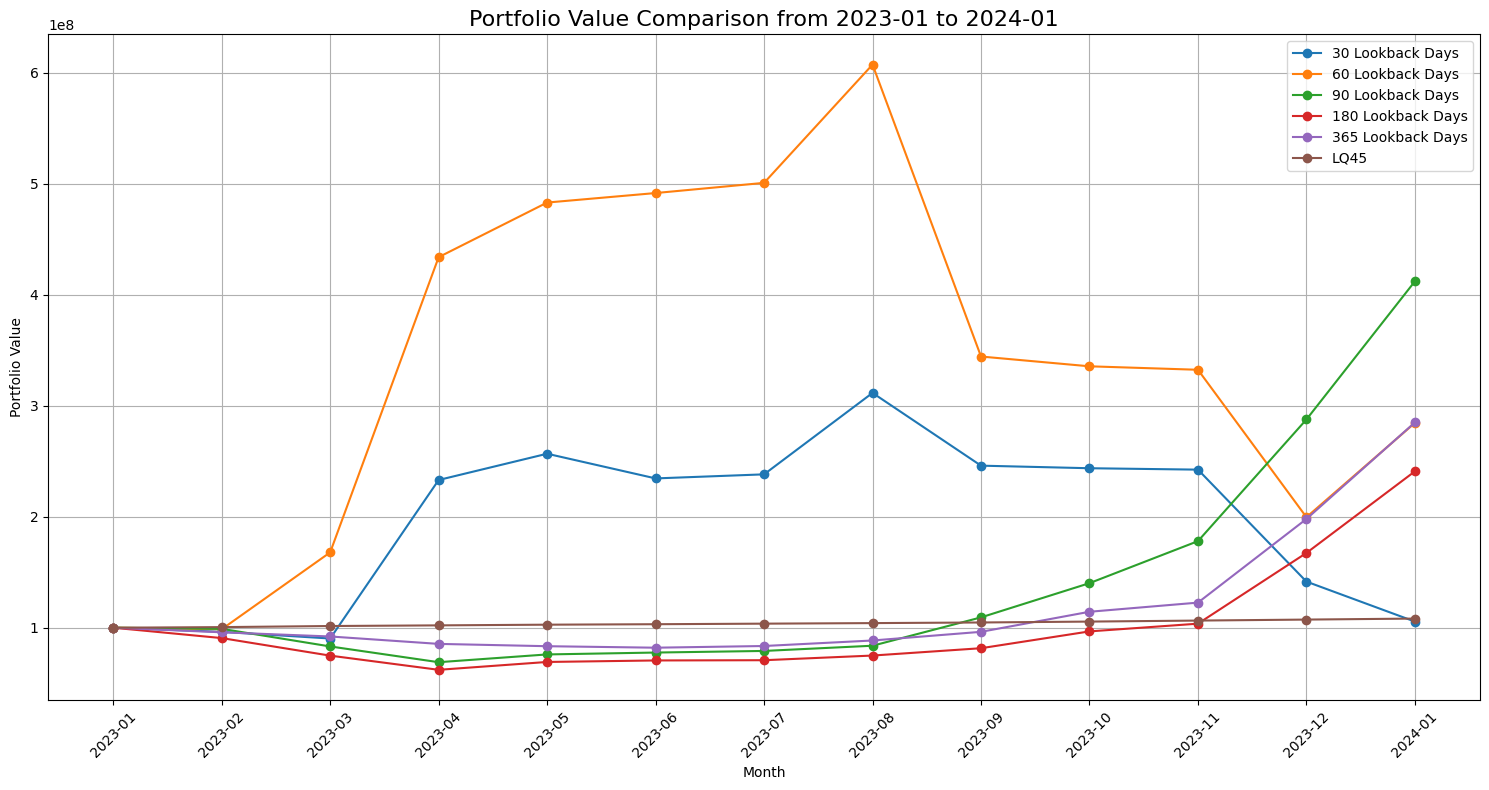

In [48]:
dataframes = [final_30, final_60, final_90, final_180, final_365, portfolio_history_lq45]
labels = ["30 Lookback Days", "60 Lookback Days", "90 Lookback Days", "180 Lookback Days", "365 Lookback Days", "LQ45"]

plt.figure(figsize=(15, 8))
for df, label in zip(dataframes, labels):
    plt.plot(df['Period'], df['portfolio_value'], marker='o', label=label)

plt.xlabel('Month')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Value Comparison from 2023-01 to 2024-01', fontsize=16)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [49]:
def calculate_metrics(df_1, df_2, label):
    annualized_return = (df_2['portfolio_value'].iloc[-1] / df_2['portfolio_value'].iloc[0] - 1) * 100
    # volatility = df_1['portfolio_risk'].iloc[-1]
    # drawdown = max(0, (df_2['portfolio_value'].max() - df_2['portfolio_value'].min()))

    return {
        'Label': label,
        'Annualized Return': f"{annualized_return:.2f}%",
        # 'Risk - Volatility': f"{volatility:.2f}%",
        # 'Drawdown': f"{drawdown:.2f}%",
    }

metrics_list = []
metrics_list.append(calculate_metrics(df_30, final_30, "30 Lookback Days Portfolio"))
metrics_list.append(calculate_metrics(df_60, final_60, "60 Lookback Days Portfolio"))
metrics_list.append(calculate_metrics(df_90, final_90, "90 Lookback Days Portfolio"))
metrics_list.append(calculate_metrics(df_180, final_180, "180 Lookback Days Portfolio"))
metrics_list.append(calculate_metrics(df_365, final_365, "365 Lookback Days Portfolio"))
metrics_list.append(calculate_metrics(portfolio_history_lq45, portfolio_history_lq45, "LQ45"))

print("Highlights")
# print("Return")
for metrics in metrics_list:
    print(f"{metrics['Label']}:")
    print(f"  Annualized Return: {metrics['Annualized Return']}")
    # print(f"  Risk - Volatility: {metrics['Risk - Volatility']}")
    # print(f"  Drawdown: {metrics['Drawdown']}")
    print()


Highlights
30 Lookback Days Portfolio:
  Annualized Return: 5.52%

60 Lookback Days Portfolio:
  Annualized Return: 184.58%

90 Lookback Days Portfolio:
  Annualized Return: 312.22%

180 Lookback Days Portfolio:
  Annualized Return: 140.96%

365 Lookback Days Portfolio:
  Annualized Return: 185.07%

LQ45:
  Annualized Return: 8.23%



In [52]:
# simpan file csv
# final_30.to_csv("summarized_portfolio_30_days.csv", index=False)
# final_60.to_csv("summarized_portfolio_60_days.csv", index=False)
# final_90.to_csv("summarized_portfolio_90_days.csv", index=False)
# final_180.to_csv("summarized_portfolio_180_days.csv", index=False)
# final_365.to_csv("summarized_portfolio_365_days.csv", index=False)